# Analysis of Models using only MIMIC Notes

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import pickle
import numpy as np
import pandas as pd

from pathlib import Path
from scipy import stats
from itertools import combinations
from tqdm import tqdm_notebook as tqdm

from utils.metrics import BinaryAvgMetrics
from utils.plots import *

In [2]:
from lr.args import args as lr_args
from rf.args import args as rf_args
from gbm.args import args as gbm_args

thresholds = {
  'lr': lr_args.threshold,
  'rf': rf_args.threshold,
  'gbm': gbm_args.threshold
}

In [3]:
path = Path('data')
workdir = path/f'workdir'
figdir = workdir/'figdir'

## Ensembles

In [4]:
def get_ensemble(ensembles, thresh, bams):  
  outputs = {}
  for ens_model in ensembles:
    key = '-'.join(ens_model)
    targs = bams[ens_model[0]].targs
    avg_thresh = np.array([thresh[model] for model in ens_model]).mean()
    max_thresh = max([thresh[model] for model in ens_model])
    probs = []
    for i in range(len(targs)):
      prob = []
      for model in ens_model:
        prob.append(bams[model].pos_probs[i])
      probs.append(np.stack(prob))

    avg_probs = [probs.mean(axis=0) for probs in probs]
    max_probs = [probs.max(axis=0) for probs in probs]

    avg_preds = [(probs > avg_thresh).astype(np.int64) for probs in avg_probs]
    max_preds = [(probs > max_thresh).astype(np.int64) for probs in max_probs]
    outputs[f'avg-{key}'] = (targs, avg_preds, avg_probs, avg_thresh)
    outputs[f'max-{key}'] = (targs, max_preds, max_probs, max_thresh)
    
  return outputs

In [5]:
def do_ttest(bams, model1, model2, metric):  
  if metric == 'sensitivity':
    x1 = bams[model1].sensitivities()
    x2 = bams[model2].sensitivities()
  elif metric == 'specificity':
    x1 = bams[model1].specificities()
    x2 = bams[model2].specificities()
  elif metric == 'ppv':
    x1 = bams[model1].ppvs()
    x2 = bams[model2].ppvs()
  elif metric == 'auroc':
    x1 = bams[model1].aurocs()
    x2 = bams[model2].aurocs()
  elif metric == 'npv':
    x1 = bams[model1].npvs()
    x2 = bams[model2].npvs()
  elif metric == 'f1':    
    x1 = bams[model1].f1s()
    x2 = bams[model2].f1s()

  t, p = stats.ttest_ind(x1, x2)
  return np.round(t, 2), max(np.round(p, 2), 0.001)

### Compute Average Ensembles

In [6]:
models = ['lr', 'rf', 'gbm']
bams = {}

for model in models:
  with open(workdir/model/f'preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    probs = pickle.load(f)
    preds = pickle.load(f)
  bams[model] = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])

In [7]:
# ens_models = [
#   ['lr', 'rf'],
#   ['lr', 'gbm'],
#   ['rf', 'gbm'],  
#   ['lr', 'rf', 'gbm'],
# ]

ens_models = [m for m in sum([list(map(list, combinations(models, i))) for i in range(len(models) + 1)], []) if len(m) > 1]

In [8]:
ensembles = get_ensemble(ens_models, thresholds, bams)

for model, vals in ensembles.items():
  bams[model] = BinaryAvgMetrics(*vals[:-1])  

In [9]:
final_metrics = {}

for key in bams.keys():
  final_metrics[key] = []
  for i in range(len(bams[key].get_avg_metrics())):
    final_metrics[key].append(bams[key].get_avg_metrics().iloc[i]['Value'])

In [10]:
final_metrics = pd.DataFrame(final_metrics, index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1']).transpose()

best_models = pd.DataFrame([(final_metrics[metric].idxmax(), final_metrics[metric].max()) for metric in final_metrics], columns=['model', 'value'], index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1'])

### Student-t Tests

In [11]:
models = list(final_metrics.index)
metrics = list(final_metrics.columns)

In [12]:
ttests = {}

for m1, m2 in combinations(models, 2):  
  ttests[f'{m1}:{m2}'] = {}
  for metric in metrics:
    ttests[f'{m1}:{m2}'][metric] = do_ttest(bams, m1, m2, metric)

ttests = pd.DataFrame(ttests).transpose()

### Save to disk

In [13]:
pickle.dump(bams, open(workdir/'bams.pkl', 'wb'))
final_metrics.to_csv(workdir/'final_metrics.csv', float_format='%.3f')
best_models.to_csv(workdir/'best_models.csv', float_format='%.3f')
ttests.to_csv(workdir/'ttests.csv')

## Results

In [4]:
bams = pickle.load(open(workdir/'bams.pkl', 'rb'))
final_metrics = pd.read_csv(workdir/'final_metrics.csv', index_col=0)
best_models = pd.read_csv(workdir/'best_models.csv', index_col=0)
ttests = pd.read_csv(workdir/'ttests.csv', index_col=0)

In [5]:
itr = iter(bams.keys())
bams.keys()

dict_keys(['lr', 'rf', 'gbm', 'avg-lr-rf', 'max-lr-rf', 'avg-lr-gbm', 'max-lr-gbm', 'avg-rf-gbm', 'max-rf-gbm', 'avg-lr-rf-gbm', 'max-lr-rf-gbm'])

In [16]:
model = next(itr)
print(model)
bams[model].get_avg_metrics(conf=0.95)

max-lr-rf-gbm


,Mean,Lower,Upper
sensitivity,0.758,0.752,0.765
specificity,0.577,0.574,0.580
ppv,0.059,0.057,0.060
auroc,0.733,0.729,0.736
npv,0.986,0.985,0.986
f1,0.109,0.106,0.111


In [ ]:
final_metrics

In [19]:
best_models

,model,value
sensitivity,max-lr-rf-gbm,0.758
specificity,lr,0.697
ppv,avg-lr-gbm,0.068
auroc,avg-lr-gbm,0.740
npv,max-lr-rf-gbm,0.986
f1,avg-lr-gbm,0.124


In [ ]:
print(ttests.to_latex())

## Box Plot

In [27]:
bams = pickle.load(open(workdir/'bams.pkl', 'rb'))
final_metrics = pd.read_csv(workdir/'final_metrics.csv', index_col=0)
best_models = pd.read_csv(workdir/'best_models.csv', index_col=0)
ttests = pd.read_csv(workdir/'ttests.csv', index_col=0)

for k in bams.keys():
  bams[k.upper()] = bams.pop(k)

bams['AVG-ALL'] = bams.pop('AVG-LR-RF-GBM')
bams['MAX-ALL'] = bams.pop('MAX-LR-RF-GBM')

In [28]:
itr = iter(bams.keys())
bams.keys()

metrics = {}

for md in itr:
  df = pd.DataFrame()
  for k, m in bams[md].yield_metrics():
    df[k] = m
  df['model'] = md
  cols = list(df.columns)
  cols = [cols[-1]] + cols[:-1]
  df = df[cols]
  metrics[md] = df

plot_df = pd.concat(metrics.values())

In [29]:
save = True

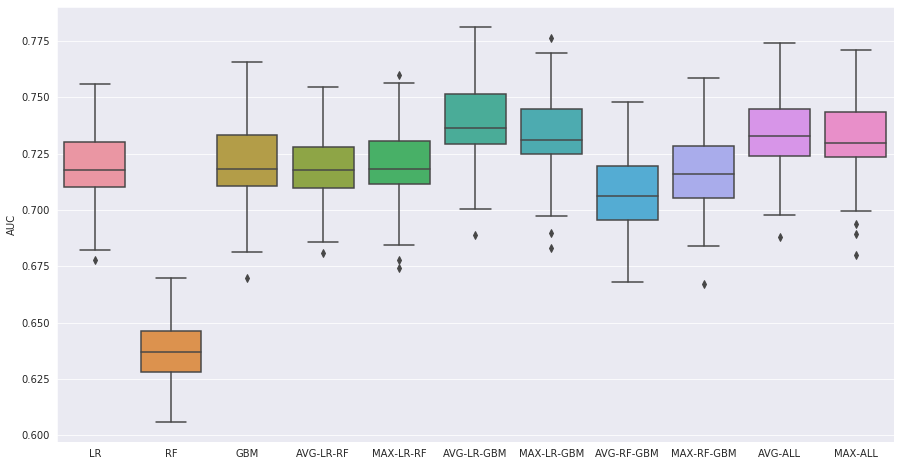

In [35]:
met = 'AUC'

fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.boxplot(x='model', y=met, data=plot_df, ax=ax)
ax.set_xlabel('')

if save:
  fig.savefig(figdir/f'{met.lower()}_box_plot.pdf', dpi=300)

## Mean AUC

In [36]:
def get_mean_tprs(bams, base_fpr):
  mean_tprs = {}  
  for model, bam in bams.items():
    tprs = []  
    for i, (targs, probs) in enumerate(zip(bam.targs, bam.pos_probs)):
      fpr, tpr, _ = roc_curve(targs, probs)
      tpr = interp(base_fpr, fpr, tpr)
      tpr[0] = 0.0
      tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs[model] = tprs.mean(axis=0)
    
  return mean_tprs

In [54]:
des = 'all_'

if not des:
  plot_bams = {k: bams[k] for k in bams.keys() if '-' not in k}
  des = ''  
  names = plot_bams.keys()
  aucs = [model.auroc_avg() for _, model in plot_bams.items()]
  legends = [f'{model} ({auc})' for model, auc in zip(names, aucs)]
elif des == 'avg_':
  plot_bams = {k: bams[k] for k in bams.keys() if 'AVG' in k}
  names = [name[4:] for name in plot_bams.keys()]
  aucs = [model.auroc_avg() for _, model in plot_bams.items()]
  legends = [f'{model} ({auc})' for model, auc in zip(names, aucs)]  
elif des == 'max_':
  plot_bams = {k: bams[k] for k in bams.keys() if 'MAX' in k}
  names = [name[4:] for name in plot_bams.keys()]
  aucs = [model.auroc_avg() for _, model in plot_bams.items()]
  legends = [f'{model} ({auc})' for model, auc in zip(names, aucs)]  
elif des == 'all_':
  plot_bams = bams
  names = plot_bams.keys()
  aucs = [model.auroc_avg() for _, model in plot_bams.items()]
  legends = [f'{model} ({auc})' for model, auc in zip(names, aucs)]
  
legends  

['LR (0.72)',
 'RF (0.637)',
 'GBM (0.721)',
 'AVG-LR-RF (0.72)',
 'MAX-LR-RF (0.72)',
 'AVG-LR-GBM (0.74)',
 'MAX-LR-GBM (0.734)',
 'AVG-RF-GBM (0.708)',
 'MAX-RF-GBM (0.718)',
 'AVG-ALL (0.735)',
 'MAX-ALL (0.733)']

In [55]:
save = True

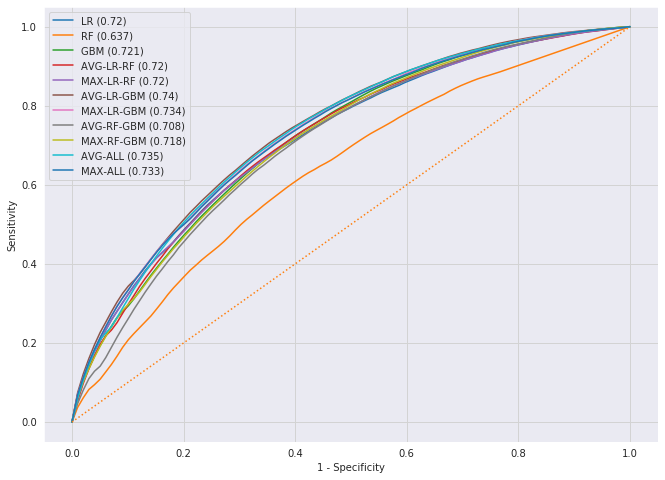

In [56]:
base_fpr = np.linspace(0, 1, 100)
mean_tprs = get_mean_tprs(plot_bams, base_fpr)

fig, ax = plt.subplots(1, 1, figsize=(11, 8))
for i, (model, mean_tpr) in enumerate(mean_tprs.items()):
  ax.plot(base_fpr, mean_tpr)
ax.plot([0, 1], [0, 1], linestyle=':')  
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1 - Specificity')
ax.legend(legends)

if save:
  fig.savefig(figdir/f'{des}mean_auc.pdf', dpi=300)